In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

**Generating Synthetic Dataset**

In [2]:
np.random.seed(42)
n_samples = 500

data = {
    'customer_id': [f"CUST_{i:04d}" for i in range(n_samples)],
    'tenure': np.random.randint(1, 36, n_samples),
    'monthly_charges': np.random.uniform(10, 100, n_samples),
    'total_charges': np.random.uniform(50, 3000, n_samples),
    'num_logins': np.random.randint(1, 100, n_samples),
    'support_calls': np.random.randint(0, 10, n_samples),
}

df = pd.DataFrame(data)

In [3]:
df.head()

,customer_id,tenure,monthly_charges,total_charges,num_logins,support_calls
0,CUST_0000,29,72.587001,2546.903155,13,0
1,CUST_0001,15,16.789109,2867.947123,23,6
2,CUST_0002,8,24.959389,506.282816,83,4
3,CUST_0003,21,29.512820,1888.831025,75,7
4,CUST_0004,19,36.504455,1449.000061,1,7


In [4]:
df['churn_risk_score'] = (
    (df['support_calls'] > 5).astype(int) +
    (df['tenure'] < 6).astype(int) +
    (df['num_logins'] < 10).astype(int)
)
df['is_active'] = (df['churn_risk_score'] < 2).astype(int)  # churn if score >= 2
df.drop(columns=['churn_risk_score'], inplace=True)

**Prepare Data**

In [5]:
X = df.drop(columns=['customer_id', 'is_active'])
y = df['is_active']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [6]:
# Only train autoencoder on non-churned (active = 1)
X_train_normal = X_train[y_train == 1]

**Build Autoencoder**

In [7]:
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(6, activation='relu')(input_layer)
encoded = Dense(3, activation='relu')(encoded)
decoded = Dense(6, activation='relu')(encoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')


**Train Autoencoder**

In [ ]:
autoencoder.fit(X_train_normal, X_train_normal,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test, X_test))

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1.1004 - val_loss: 1.1063
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0913 - val_loss: 1.0788
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0326 - val_loss: 1.0587
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9950 - val_loss: 1.0438
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9838 - val_loss: 1.0325
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9674 - val_loss: 1.0235
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9931 - val_loss: 1.0171
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9526 - val_loss: 1.0118
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9554 - val_loss: 1.0068
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9334 - val_loss: 1.0022
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9559 - val_loss: 0.9976
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9444 - val_

**Reconstruction Error**

In [9]:
reconstructions = autoencoder.predict(X_test)
mse = np.mean(np.square(X_test - reconstructions), axis=1)

# Set threshold as 95th percentile of normal reconstruction errors
threshold = np.percentile(mse[y_test == 1], 95)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [10]:
y_pred = (mse > threshold).astype(int)  # 1 = predicted churn, 0 = retained
y_true = (y_test == 0).astype(int)      # 1 = actual churn

In [11]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Retained", "Churned"]))

Classification Report:
              precision    recall  f1-score   support

    Retained       0.88      0.94      0.91        88
     Churned       0.17      0.08      0.11        12

    accuracy                           0.84       100
   macro avg       0.52      0.51      0.51       100
weighted avg       0.80      0.84      0.82       100



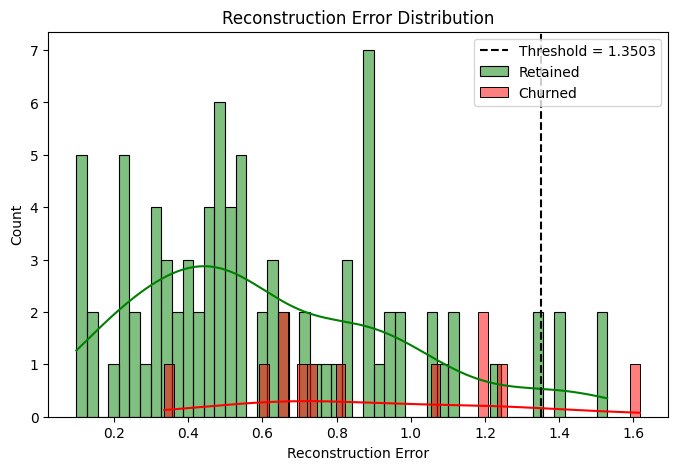

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc

# 1. Reconstruction Error Distribution
plt.figure(figsize=(8, 5))
sns.histplot(mse[y_test == 1], bins=50, label='Retained', color='green', kde=True)
sns.histplot(mse[y_test == 0], bins=50, label='Churned', color='red', kde=True)
plt.axvline(threshold, color='black', linestyle='--', label=f"Threshold = {threshold:.4f}")
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Count')
plt.legend()
plt.show()

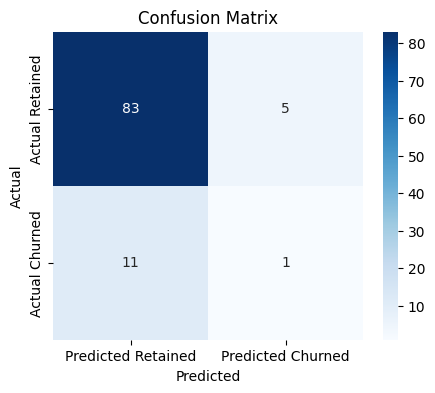

In [14]:
# 2. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Predicted Retained", "Predicted Churned"],
            yticklabels=["Actual Retained", "Actual Churned"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

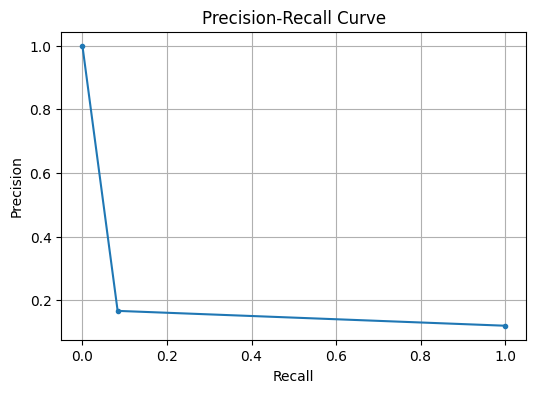

In [15]:
# 3. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, mse > threshold)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

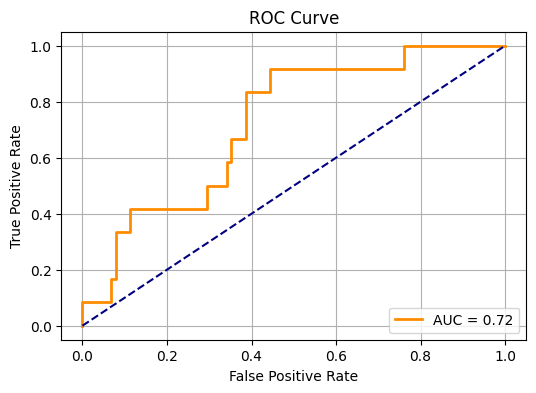

In [16]:
# 4. ROC Curve
fpr, tpr, _ = roc_curve(y_true, mse)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [19]:
df.to_csv("synthetic_subscription_churn.csv", index=False)
print("Download the file!")

Download the file!
